In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle

Image shape: <PIL.Image.Image image mode=L size=768x512 at 0x16B4660AA90>
Pixel values:
 [[113 114 117 ...  41  41  42]
 [117 117 118 ...  42  42  41]
 [121 121 122 ...  42  41  41]
 ...
 [ 72  73  76 ...  65  56  48]
 [ 71  72  73 ...  62  54  51]
 [  0   0   0 ...   0   0   0]]


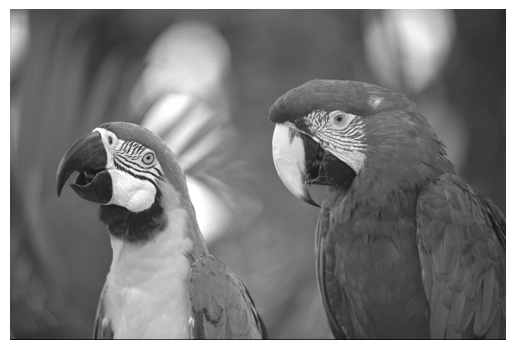

In [34]:
image_path = 'Photos/23.png' 
image = Image.open(image_path).convert('L')
image_array = np.array(image)


print("Image shape:", image)
print("Pixel values:\n", image_array)

plt.imshow(image_array,cmap='gray')
plt.axis('off')
plt.show()

In [35]:
height, width = image_array.shape

pad_height = (8 - (height % 8)) % 8
pad_width = (8 - (width % 8)) % 8

# Apply zero padding
padded_image = np.pad(
    image_array,
    ((0, pad_height), (0, pad_width)),
    mode='constant',
    constant_values=255
)

# Print results
print(f"Original shape: {image_array.shape}")
print(f"Padded shape: {padded_image.shape}")

Original shape: (512, 768)
Padded shape: (512, 768)


Original padded image pixel range: [0, 255]
Centered image pixel range: [0, 255]


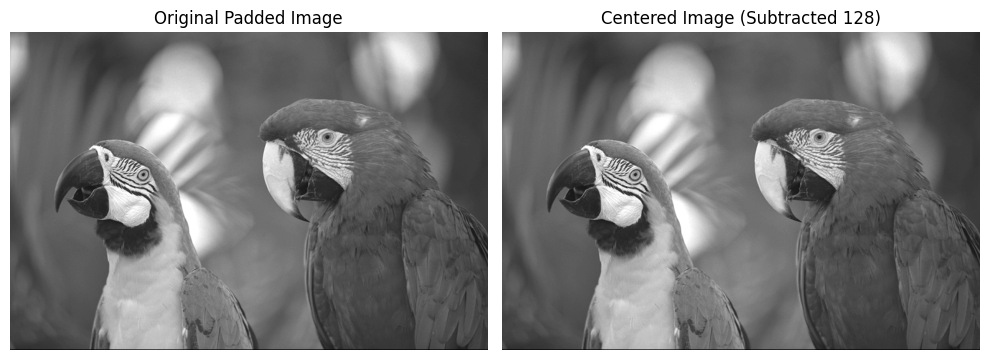

In [36]:
# Subtract 128 from each pixel
centered_image = padded_image - 0

# Print some information to verify
print(f"Original padded image pixel range: [{padded_image.min()}, {padded_image.max()}]")
print(f"Centered image pixel range: [{centered_image.min()}, {centered_image.max()}]")

# Visualize the centered image
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(padded_image, cmap='gray')
plt.title('Original Padded Image')
plt.axis('off')

# Centered image
plt.subplot(1, 2, 2)
plt.imshow(centered_image, cmap='gray')
plt.title('Centered Image (Subtracted 128)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
#Step 1 : 8X8 blocks
height, width = centered_image.shape

# Create 8x8 blocks
blocks = centered_image.reshape(height // 8, 8, width // 8, 8).swapaxes(1, 2)

# Print shape of the blocks
print(f"Shape of blocks array: {blocks.shape}")  # (num_blocks_y, num_blocks_x, 8, 8)

# Example: Accessing the first block
first_block = blocks[0, 0]
print(f"First block:\n{first_block}")


Shape of blocks array: (64, 96, 8, 8)
First block:
[[113 114 117 115 117 117 114 119]
 [117 117 118 118 117 119 119 118]
 [121 121 122 123 122 122 123 122]
 [126 122 126 126 126 126 129 126]
 [130 128 130 132 130 130 130 129]
 [134 133 130 137 137 133 133 135]
 [141 137 134 137 141 139 138 142]
 [144 138 141 142 142 146 145 144]]


In [38]:
#Step 2
from scipy.fftpack import dct,idct
def apply_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def apply_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Perform DCT on all blocks
dct_coefficients = np.empty_like(blocks, dtype=np.float64)  # Preallocate array for DCT coefficients
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        dct_coefficients[i, j] = apply_dct(blocks[i, j])

# Example: Accessing the DCT coefficients of the first block
print(f"DCT Coefficients of the first block:\n{dct_coefficients[9, 6]}")

print(dct_coefficients.shape)

DCT Coefficients of the first block:
[[ 7.77750000e+02  1.15623512e+01  1.07559308e+00 -9.30664519e-01
  -5.00000000e-01  3.63806614e-01  6.36866958e-01 -8.29784914e-01]
 [-1.24909016e+00 -2.22390079e+00 -1.54562439e+00  9.45640745e-01
   1.89361627e+00 -7.57235795e-01 -1.71692718e-01  1.80662128e+00]
 [-1.60037466e+00 -6.09018138e-01 -1.25000000e-01  1.12704809e+00
   1.95984445e+00  7.86770444e-01  1.05177670e+00 -5.90987159e-02]
 [-1.56872308e+00 -2.03044944e+00  1.06913925e+00  9.00923305e-01
   2.00773311e-01 -1.54009013e+00  2.52111227e-01  2.06399786e+00]
 [-7.50000000e-01  1.43752407e-01  6.13653315e-01  1.66431469e+00
  -1.50000000e+00 -1.17946149e+00  8.28208674e-01 -8.32623844e-01]
 [-1.97757157e-01 -1.47300760e+00 -2.01581477e+00 -1.32042021e+00
   2.58695042e-01  3.36513562e-01 -4.06856477e-01  1.03434039e-01]
 [ 2.01588714e+00 -4.47537166e-01 -6.98223305e-01 -2.93702670e+00
   8.11794150e-01  1.74985097e+00 -1.25000000e-01  3.12994179e-01]
 [-9.69419302e-01  5.26291194e-0

In [39]:
# Step 3 : Quantization

Tb = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Define the quality factor Q
Q = 80

# Calculate the scaling factor S
if Q < 50:
    S = 5000 / Q
else:
    S = 200 - 2 * Q

Ts = np.floor((S * Tb + 50) / 100).astype(int)
Ts[Ts == 0] = 1  # Prevent divide by zero

# Perform quantization on the DCT coefficients
quantized_coefficients = np.empty_like(dct_coefficients, dtype=np.int32)  # Preallocate array
for i in range(dct_coefficients.shape[0]):
    for j in range(dct_coefficients.shape[1]):
        quantized_coefficients[i, j] = np.round(dct_coefficients[i, j] / Ts).astype(int)

Ts

array([[ 6,  4,  4,  6, 10, 16, 20, 24],
       [ 5,  5,  6,  8, 10, 23, 24, 22],
       [ 6,  5,  6, 10, 16, 23, 28, 22],
       [ 6,  7,  9, 12, 20, 35, 32, 25],
       [ 7,  9, 15, 22, 27, 44, 41, 31],
       [10, 14, 22, 26, 32, 42, 45, 37],
       [20, 26, 31, 35, 41, 48, 48, 40],
       [29, 37, 38, 39, 45, 40, 41, 40]])

In [40]:
np.array(quantized_coefficients).shape

(64, 96, 8, 8)

In [41]:
# Zigzag scanning
zigzag_order = np.array([
    [0,  1,  5,  6, 14, 15, 27, 28],
    [2,  4,  7, 13, 16, 26, 29, 42],
    [3,  8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

def zigzag_scan(block):
    flat_block = np.zeros(block.shape[0]*block.shape[1])
    for i in range(8):
        for j in range(8):
            flat_block[zigzag_order[i][j]] = block[i][j]
    return flat_block

In [42]:
# Run-length encoding
def run_length_encode(zigzag_array):
    rle = []
    zero_count = 0
    for value in zigzag_array:
        if value == 0:
            zero_count += 1
        else:
            rle.append((zero_count, value))
            zero_count = 0
    if zero_count > 0:  # Handle trailing zeros
        rle.append((zero_count, 0))
    return rle


rle_encoded_blocks = []
flattened_blocks = []
# Loop over all rows and columns of blocks
for i in range(quantized_coefficients.shape[0]):  # Number of rows of blocks
    for j in range(quantized_coefficients.shape[1]):  # Number of columns of blocks
        flattened_block = zigzag_scan(quantized_coefficients[i, j])
        flattened_blocks.append(flattened_block)
        rle_encoded_block = run_length_encode(flattened_block)
        rle_encoded_blocks.append(rle_encoded_block)  # Append RLE for each block

# Final check
print(f"Total number of blocks: {len(rle_encoded_blocks)}")


Total number of blocks: 6144


In [43]:
rle_encoded_blocks[0]

[(0, 171.0), (0, -2.0), (0, -14.0), (0, 1.0), (5, -1.0), (3, -1.0), (50, 0)]

In [44]:
from collections import defaultdict
import heapq

# Step 1: Create Huffman encoding class
class HuffmanCoding:
    def __init__(self):
        self.heap = []
        self.codes = {}
        self.reverse_codes = {}
    
    class HeapNode:
        def __init__(self, char, freq):
            self.char = char
            self.freq = freq
            self.left = None
            self.right = None
        
        def __lt__(self, other):
            return self.freq < other.freq
    
    # Calculate frequency of symbols
    def make_frequency_dict(self, data):
        frequency = defaultdict(int)
        for item in data:
            frequency[item] += 1
        return frequency
    
    # Create min heap of frequencies
    def make_heap(self, frequency):
        for key in frequency:
            node = self.HeapNode(key, frequency[key])
            heapq.heappush(self.heap, node)
    
    # Build Huffman Tree
    def merge_nodes(self):
        while len(self.heap) > 1:
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            
            merged = self.HeapNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            
            heapq.heappush(self.heap, merged)
    
    # Create codes recursively
    def make_codes_recursive(self, root, current_code):
        if root is None:
            return
        
        if root.char is not None:
            self.codes[root.char] = current_code
            self.reverse_codes[current_code] = root.char
            return
        
        self.make_codes_recursive(root.left, current_code + "0")
        self.make_codes_recursive(root.right, current_code + "1")
    
    # Main encoding function
    def make_codes(self):
        root = heapq.heappop(self.heap)
        self.make_codes_recursive(root, "")
    
    # Convert RLE tuples to a format suitable for Huffman encoding
    def prepare_rle_data(self, rle_data):
        prepared_data = []
        for block in rle_data:
            for zero_count, value in block:
                prepared_data.append((zero_count, value))
        return prepared_data
    
    # Encode the data
    def encode(self, rle_data):
        prepared_data = self.prepare_rle_data(rle_data)
        frequency = self.make_frequency_dict(prepared_data)
        self.make_heap(frequency)
        self.merge_nodes()
        self.make_codes()
        
        encoded_data = []
        for block in rle_data:
            block_encoding = []
            for pair in block:
                block_encoding.append(self.codes[pair])
            encoded_data.append(block_encoding)
        
        return encoded_data, self.codes, self.reverse_codes

In [45]:
# Perform Huffman encoding
huffman = HuffmanCoding()
encoded_data, huffman_codes, reverse_huffman_codes = huffman.encode(rle_encoded_blocks)

# Print some statistics
print("\nHuffman Encoding Statistics:")
print(f"Number of unique symbols: {len(huffman_codes)}")
print(f"Sample of Huffman codes:")
sample_items = list(huffman_codes.items())[:5]
for item, code in sample_items:
    print(f"Symbol {item}: {code}")



Huffman Encoding Statistics:
Number of unique symbols: 676
Sample of Huffman codes:
Symbol (59, 0): 00000000
Symbol (56, 0): 00000001
Symbol (51, 0): 0000001
Symbol (3, 1.0): 000001
Symbol (1, -5.0): 0000100000


In [46]:
len(encoded_data)

6144

In [47]:
# Save the compressed data
compressed_data = {
    'encoded_data': encoded_data,
    'huffman_codes': huffman_codes,
    'image_shape': padded_image.shape,
    'quantization_matrix': Ts,
}

# Calculate compression metrics
original_size = padded_image.size * padded_image.itemsize  # Size in bytes
compressed_size = sum(len(''.join(block)) for block in encoded_data) // 8  # Approximate size in bytes

print("\nCompression Metrics:")
print(f"Original size: {original_size} bytes")
print(f"Compressed size (approximate): {compressed_size} bytes")
print(f"Compression ratio: {original_size / compressed_size:.2f}:1")

# Save compressed data to file
with open('compressed_image.bin', 'wb') as f:
    pickle.dump(compressed_data, f)


Compression Metrics:
Original size: 393216 bytes
Compressed size (approximate): 47638 bytes
Compression ratio: 8.25:1


# Decode

In [48]:
# Load the compressed data
with open('compressed_image.bin', 'rb') as f:
    compressed_data = pickle.load(f)

# Extract components from compressed data
encoded_data_ = compressed_data['encoded_data']
huffman_codes_ = compressed_data['huffman_codes']
image_shape = compressed_data['image_shape']
Ts = compressed_data['quantization_matrix']  # Quantization matrix


In [49]:
Ts

array([[ 6,  4,  4,  6, 10, 16, 20, 24],
       [ 5,  5,  6,  8, 10, 23, 24, 22],
       [ 6,  5,  6, 10, 16, 23, 28, 22],
       [ 6,  7,  9, 12, 20, 35, 32, 25],
       [ 7,  9, 15, 22, 27, 44, 41, 31],
       [10, 14, 22, 26, 32, 42, 45, 37],
       [20, 26, 31, 35, 41, 48, 48, 40],
       [29, 37, 38, 39, 45, 40, 41, 40]])

In [50]:
# Step 1: Huffman Decoding
reverse_huffman_codes = {code: symbol for symbol, code in huffman_codes_.items()}
decoded_rle_blocks = []

for block_codes in encoded_data_:
    block_rle = []
    for code in block_codes:
        block_rle.append(reverse_huffman_codes[code])
    decoded_rle_blocks.append(block_rle)

In [51]:
# Step 2: Run-Length Decoding
def run_length_decode(rle_data):
    decoded = []
    for zero_count, value in rle_data:
        decoded.extend([0] * zero_count)
        decoded.append(value)
    return np.array(decoded[:64])
    #return np.array(decoded) error of one extra trailing zero

decoded_zigzag_blocks = [run_length_decode(block) for block in decoded_rle_blocks]

In [52]:
# Step 3: Inverse Zigzag Scanning
import numpy as np

# Define the zigzag order for an 8x8 matrix
zigzag_order = np.array([
    [0,  1,  5,  6, 14, 15, 27, 28],
    [2,  4,  7, 13, 16, 26, 29, 42],
    [3,  8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])
decoded_blocks = []
for zigzag_data in decoded_zigzag_blocks:
    decoded_block = np.zeros((8,8),dtype=int)
    # Fill the inverse mapping using nested loops
    for i in range(8):
        for j in range(8):
            # Get the zigzag index from zigzag_order[i, j]
            zigzag_index = zigzag_order[i, j]
            decoded_block[i][j] = zigzag_data[zigzag_index]
    decoded_blocks.append(decoded_block)
decoded_blocks = np.array(decoded_blocks)

In [53]:
# Reshape into (num_rows, num_cols, 8, 8)
decoded_coefficients = decoded_blocks.reshape(image_shape[0]//8, image_shape[1]//8, 8, 8)

print(f"Decoded blocks shape: {decoded_coefficients.shape}")  # Should output (54, 80, 8, 8)


Decoded blocks shape: (64, 96, 8, 8)


In [54]:
# Step 4: Dequantization
dequantized_blocks = []
for block in decoded_coefficients:
    dequantized = block * Ts  # Multiply by quantization matrix
    dequantized_blocks.append(dequantized)

dequantized_blocks = np.array(dequantized_blocks)


In [55]:
dequantized_blocks[0][0]

array([[1026,   -8,    0,    0,    0,    0,    0,    0],
       [ -70,    0,    0,   -8,    0,    0,    0,    0],
       [   6,    0,    0,    0,    0,    0,    0,    0],
       [  -6,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [56]:
np.array(dct_coefficients[0][0],dtype=int)

array([[1026,   -6,    0,    2,    3,    1,    1,    0],
       [ -72,    0,   -1,   -4,   -3,    0,    0,    0],
       [   3,   -2,    1,    0,    0,   -2,    2,    0],
       [  -6,    1,   -1,   -1,    3,   -3,    0,   -1],
       [   1,   -1,    0,    0,   -1,    2,    2,    1],
       [   0,   -1,    1,    0,    1,   -2,    0,    1],
       [   0,    0,   -2,   -1,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0,   -1,    0,    0]])

In [57]:
reconstructed_blocks = np.empty_like(blocks, dtype=np.uint8)  # Preallocate array for DCT coefficients
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        reconstructed_block = apply_idct(np.round(dequantized_blocks[i,j]))
        reconstructed_block = np.round(reconstructed_block).astype(np.uint8)
        reconstructed_blocks[i, j] = reconstructed_block

In [58]:
reconstructed_blocks[9][6]

array([[100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95],
       [100,  99,  99,  98,  97,  96,  96,  95]], dtype=uint8)

In [59]:
blocks[9][6]

array([[ 98,  96,  97,  96,  98,  96,  95,  96],
       [100,  98,  97,  97,  97,  96,  95,  95],
       [ 99,  99, 100, 100,  97,  95,  96,  96],
       [ 98, 100,  99,  99,  96,  97,  96,  95],
       [100, 101,  98,  94,  96,  97,  95,  95],
       [ 99,  99, 100,  99,  96,  95,  97,  97],
       [ 99,  99,  98,  97,  96,  96,  95,  95],
       [101, 100,  99,  99,  94,  97,  95,  95]], dtype=uint8)

In [60]:
# Dimensions of the block grid
num_rows, num_cols, block_size = dequantized_blocks.shape[0], dequantized_blocks.shape[1], dequantized_blocks.shape[2]

# Reconstruct the full image from blocks
image_height = num_rows * block_size
image_width = num_cols * block_size

# Create an empty array for the reconstructed image
decoded_image = np.zeros((image_height, image_width), dtype=np.float64)

# Populate the reconstructed image with blocks
for i in range(num_rows):
    for j in range(num_cols):
        decoded_image[
            i * block_size : (i + 1) * block_size,  # Vertical placement
            j * block_size : (j + 1) * block_size   # Horizontal placement
        ] = reconstructed_blocks[i, j]

# Add 128 to revert the centering step
decoded_image += 0

# Clip pixel values to the valid range [0, 255]
decoded_image = np.clip(decoded_image, 0, 255).astype(np.uint8)

# Save the reconstructed image if needed
reconstructed_image = Image.fromarray(decoded_image)
reconstructed_image.save("reconstructed_image.jpeg")


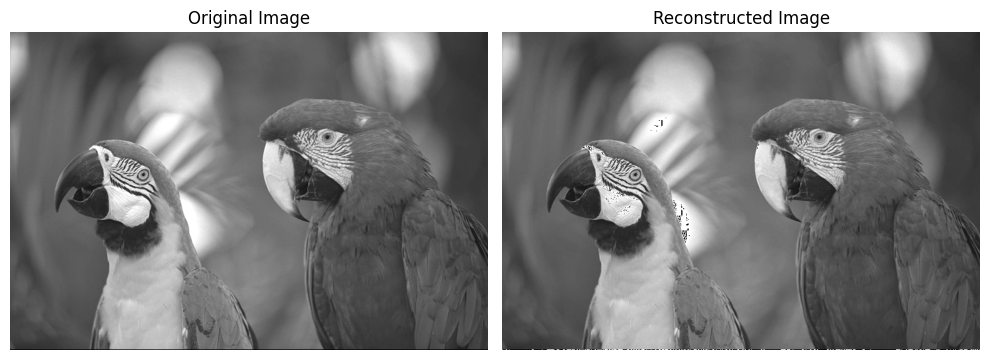

In [61]:
# Display the reconstructed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [62]:

# Calculate PSNR (Peak Signal-to-Noise Ratio)
mse = np.mean((padded_image - reconstructed_image) ** 2)
if mse == 0:
    psnr = 100
else:
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))

print(f"PSNR: {psnr:.2f} dB")

PSNR: 40.93 dB
